## Final Project Submission

Please fill out:
* __Student name:__ Cassarra Groesbeck
* __Student pace:__ Part Time (Flex)
* __Scheduled project review date/time:__ 
* __Instructor name:__ Claude Fried
* __Blog post URL:__ https://medium.com/@cassigroesbeck/data-science-i-did-it-for-the-money-57c0a26f9118


In [1]:
# potential needed imports
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from pandasql import sqldf
import sqlite3
import seaborn as sns
import numpy as np

# plot styles
plt.style.use('fivethirtyeight')
plt.style.use('seaborn-talk')

%matplotlib inline

#  -------- Analysis of Affecting Factors of Films Worldwide Gross --------

# Overview
The goal of this project is to aid _The Microsoft Production Company_ (TMPC) in optimizing the profitability of future films. The measure used to evaluate profitability for this project is worldwide gross of films. Worldwide gross has been chosen because, presumably, increased worldwide gross yields a higher return on investment. Furthermore, increased worldwide popularity likely results in boosted global merchandising opportunities, creating additional revenue sources. 

The following factors were explored to determine if and how they impact worldwide gross: 
- Production Budget
- Month of Release
- Month of Release grouped by Genre
- Rating
- Production Budget & Worldwide Gross, Grouped by Rating


# Business Problem
To begin creating original video content, Microsoft has decided to create a new movie studio: _The Microsoft Production Company_ (TMPC) . TMPC needs an assessment of the factors which contribute to a films success.

# Data
This project used data from:
-	__The Numbers__
 - 5,782 films from 1915 to 2020
-	__Rotten Tomatoes__
 -	1,559 films from 1921 to 2018
-	__IMDb__
 -	98,940 films (unknown timeframe) 

## Import Needed Data & Assign Data Frame Names

### The Numbers = tn

In [2]:
# data from: The Numbers
tn = pd.read_csv('zippedData/tn.movie_budgets.csv.gz').drop_duplicates().drop(['id', 'domestic_gross'], axis=1)

#check that it has relevent information
tn.tail()

,release_date,movie,production_budget,worldwide_gross
5777,"Dec 31, 2018",Red 11,"$7,000",$0
5778,"Apr 2, 1999",Following,"$6,000","$240,495"
5779,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338"
5780,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0
5781,"Aug 5, 2005",My Date With Drew,"$1,100","$181,041"


### Rotten Tomatoes = rt

## <font color=red>Re submission notes:</font> 
Changes:
- Did not drop 'writer'

In [3]:
# data from: Rotten Tomatoes
rt = pd.read_csv('zippedData/rt.movie_info.tsv.gz', sep='\t').drop_duplicates()\
.drop(['id', 'currency', 'box_office', 'studio', 'dvd_date', 'synopsis'], axis=1).dropna(axis=0)

#check that it has relevent information
rt.tail()

,rating,genre,director,writer,theater_date,runtime
1545,R,Horror|Mystery and Suspense,Sebastian Gutierrez,Sebastian Gutierrez,"Jun 1, 2007",98 minutes
1550,R,Art House and International|Comedy|Drama,Franco Brusati,Nino Manfredi|Franco Brusati|Iaia Fiastri,"Jun 1, 1974",112 minutes
1552,R,Comedy|Drama,Joel Coen,Joel Coen|Ethan Coen,"Aug 21, 1991",116 minutes
1556,PG,Comedy|Science Fiction and Fantasy,Steve Barron,Terry Turner|Tom Davis|Dan Aykroyd|Bonnie Turner,"Jul 23, 1993",88 minutes
1558,PG,Comedy|Drama|Kids and Family|Sports and Fitness,David Mickey Evans,David Mickey Evans|Robert Gunter,"Apr 1, 1993",101 minutes


### IMDb = imdb

## <font color=red>Re submission notes:</font> 
Updates:
- changed original query to a "directors query"
- added 'p_year' (for joining)
- changed column names with query (saves a step later)
- kept runtime (even though not using for join) to serve as visual check when joined later 
- changed WHERE clause: where primary_title and title match (reduce duplicated info)
 - This is what I was originally trying to do I think I did incorrectly


Added a second query to get a "writers query" (titles, writers, year)
- joined directors query to writers query to get 1 imdb df with writers, directors and movie year, for the purposes of using those three criteria for joining with rt (rotten tomatoes) which has the ratings

In [4]:
# data from: imdb
conn = sqlite3.connect('zippedData/im.db')# join directors d, and persons p, select primary_name as director
directors= pd.read_sql('''
    SELECT a.title as p_title, genres as imdb_genres, runtime_minutes as p_runtime_mins, p.primary_name as director, start_year as p_year 
    FROM movie_basics b
    JOIN movie_akas a 
    ON b.movie_id = a.movie_id
    JOIN directors d 
    ON d.movie_id = a.movie_id
    JOIN persons p
    ON p.person_id = d.person_id
    WHERE (primary_title = title) & (runtime_minutes != 'Nan')
    GROUP BY a.movie_id
''', conn)

#check that it has relevent information
directors.tail()

,p_title,imdb_genres,p_runtime_mins,director,p_year
98935,Padmavyuhathile Abhimanyu,Drama,130.0,Vineesh Aaradya,2019
98936,Nepal - Homebird,Documentary,52.0,Andrea Leichtfried,2019
98937,A Cherry Tale,Documentary,85.0,Eva Mulvad,2019
98938,Vida em Movimento,Documentary,70.0,Eduardo Rajabally,2019
98939,The Rehearsal,Drama,51.0,Tamar Guimaraes,2019


## <font color=red>Re submission notes:</font> 
Second query to get writers

In [5]:
writers= pd.read_sql('''
    SELECT a.title as p_title, p.primary_name as writer, start_year as p_year 
    FROM movie_basics b
    JOIN movie_akas a 
    ON b.movie_id = a.movie_id
    JOIN writers w
    ON w.movie_id = b.movie_id
    JOIN persons p
    ON p.person_id = w.person_id
    WHERE (primary_title = title) & (runtime_minutes != 'Nan')
    GROUP BY a.movie_id
''', conn)

#check that it has relevent information
writers.tail()

,p_title,writer,p_year
80427,Ormma,Suresh Thiruvalla,2019
80428,Kalikkoottukar,Bhasi Padikkal,2019
80429,Padmavyuhathile Abhimanyu,Vineesh Aaradya,2019
80430,Vida em Movimento,Joana Kfuri,2019
80431,The Rehearsal,Melissa de Raaf,2019


## <font color=red>Re submission notes:</font> 
Joining imdb 'directors' and imdb 'writers' to get 1 'imdb' df:
- use title and year to make multi-index colum in both df's
- change indices to multi_index column
- join

In [6]:
# ----------create 'multi-index' columns on directors & writers-----------------------
# tuple 'p_title' w/ 'p_year'
directors_multi_index = list(zip(directors['p_title'], directors['p_year']))
writers_multi_index = list(zip(writers['p_title'], writers['p_year']))

# add 'multi_index' columns to both df's
directors['multi_index'] = directors_multi_index
writers['multi_index'] = writers_multi_index

## <font color=red>Re submission notes:</font>
__Check__ both DF's to ensure columns were added

In [7]:
directors.tail()

,p_title,imdb_genres,p_runtime_mins,director,p_year,multi_index
98935,Padmavyuhathile Abhimanyu,Drama,130.0,Vineesh Aaradya,2019,"(Padmavyuhathile Abhimanyu, 2019)"
98936,Nepal - Homebird,Documentary,52.0,Andrea Leichtfried,2019,"(Nepal - Homebird, 2019)"
98937,A Cherry Tale,Documentary,85.0,Eva Mulvad,2019,"(A Cherry Tale, 2019)"
98938,Vida em Movimento,Documentary,70.0,Eduardo Rajabally,2019,"(Vida em Movimento, 2019)"
98939,The Rehearsal,Drama,51.0,Tamar Guimaraes,2019,"(The Rehearsal, 2019)"


In [8]:
writers.tail()

,p_title,writer,p_year,multi_index
80427,Ormma,Suresh Thiruvalla,2019,"(Ormma, 2019)"
80428,Kalikkoottukar,Bhasi Padikkal,2019,"(Kalikkoottukar, 2019)"
80429,Padmavyuhathile Abhimanyu,Vineesh Aaradya,2019,"(Padmavyuhathile Abhimanyu, 2019)"
80430,Vida em Movimento,Joana Kfuri,2019,"(Vida em Movimento, 2019)"
80431,The Rehearsal,Melissa de Raaf,2019,"(The Rehearsal, 2019)"


## <font color=red>Re submission notes:</font>
__Join__ to make 1 imdb DF

In [9]:
# ----------join directors to writers ON 'multi_index'-------------------------------- 
# set 'multi_index' as index for both df's
directors.set_index('multi_index', inplace=True)
writers.set_index('multi_index', inplace=True)

# assign name
imdb = directors.join(writers, how='inner', lsuffix='_left')

# reset indices
directors = directors.reset_index()
writers = writers.reset_index()
imdb = imdb.reset_index()

## <font color=red>Re submission notes:</font>
__Check__ imdb DF

In [10]:
imdb.tail()

,multi_index,p_title_left,imdb_genres,p_runtime_mins,director,p_year_left,p_title,writer,p_year
81735,"(à propos: philosophie, 2016)",à propos: philosophie,Documentary,80.0,Sebastian Köthe,2016,à propos: philosophie,Sebastian Köthe,2016
81736,"(ärtico, 2014)",ärtico,Drama,78.0,Gabriel Velázquez,2014,ärtico,Gabriel Velázquez,2014
81737,"(è solo questione di punti di vista, 2012)",è solo questione di punti di vista,"Action,Adventure,Comedy",103.0,Brando Improta,2012,è solo questione di punti di vista,Carl Barks,2012
81738,"(è solo questione di tempo, 2013)",è solo questione di tempo,Comedy,72.0,Brando Improta,2013,è solo questione di tempo,Brando Improta,2013
81739,"(Šiška Deluxe, 2015)",Šiška Deluxe,"Comedy,Drama",108.0,Jan Cvitkovic,2015,Šiška Deluxe,Jan Cvitkovic,2015


## <font color=red>Re submission notes:</font>
__Drop__ unnecessary columns and __Final check__

In [11]:
# remove unnecessary column(s)
imdb.drop(['multi_index', 'p_title_left', 'p_year_left'], axis=1, inplace=True)

# FINAL CHECK
imdb.tail()

,imdb_genres,p_runtime_mins,director,p_title,writer,p_year
81735,Documentary,80.0,Sebastian Köthe,à propos: philosophie,Sebastian Köthe,2016
81736,Drama,78.0,Gabriel Velázquez,ärtico,Gabriel Velázquez,2014
81737,"Action,Adventure,Comedy",103.0,Brando Improta,è solo questione di punti di vista,Carl Barks,2012
81738,Comedy,72.0,Brando Improta,è solo questione di tempo,Brando Improta,2013
81739,"Comedy,Drama",108.0,Jan Cvitkovic,Šiška Deluxe,Jan Cvitkovic,2015


## <font color=red>Re submission notes:</font>
I notice the writer columns are formatted differently between imdb & rt, this will may need to be addressed before joining. I will first try joining with director and year. Then I will use writer columns from each DF to check if it appears data was joined properly. 

## Clean Data Frame's for Analysis:
Most columns needed for analysis have all been given a prefix 'p_' (prepped for analysis), this was simply for ease of tracking which columns had been 'cleaned'. Other prefixes occationally used for differentiating which db it is associated with.  Columns were renamed when possible, otherwise new columns was created and original columns dropped. 

### Clean tn (The Numbers):

__Rename__ existing column(s):

In [12]:
# ----------rename column(s) which already exist------------------------------
tn.rename(columns={"movie": "p_title"}, inplace=True) 

__Add__ new column(s) with cleaned data:

In [13]:
# ----------convert: production_budget & worldwide_gross to integer-----------
# make production_budget list as int
p_prod_budg = [int(i[1:].replace(',', '')) for i in tn.production_budget]

# make worldwide_gross list as int
p_ww_gross = [int(i[1:].replace(',', '')) for i in tn.worldwide_gross]

# add new column(s)
tn['p_prod_budg'] = p_prod_budg
tn['p_ww_gross'] = p_ww_gross

In [14]:
# ----------add 'p_date' column: yyyy-mm-dd, & 'p_month'---------------------
# drop NaN if any
tn.release_date.dropna(axis=0, inplace=True)

# add new column(s): 'p_date' & 'p_month'
tn['p_date'] = pd.to_datetime(tn['release_date'], yearfirst=True)
tn['p_month'] = pd.DatetimeIndex(tn['p_date']).month

__Check__ new column(s) were added before dropping original column(s):

In [15]:
# check new column(s) before dropping original column(s):
tn.tail()

,release_date,p_title,production_budget,worldwide_gross,p_prod_budg,p_ww_gross,p_date,p_month
5777,"Dec 31, 2018",Red 11,"$7,000",$0,7000,0,2018-12-31,12
5778,"Apr 2, 1999",Following,"$6,000","$240,495",6000,240495,1999-04-02,4
5779,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338",5000,1338,2005-07-13,7
5780,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,1400,0,2015-09-29,9
5781,"Aug 5, 2005",My Date With Drew,"$1,100","$181,041",1100,181041,2005-08-05,8


If all is well, __Drop__ original column(s):

In [16]:
# remove old column(s)
tn.drop(['production_budget', 'worldwide_gross', 'release_date'], axis=1, inplace=True)

__Final check__ to ensure cleaned DF has required columns, in correct format.

In [17]:
# check cleaned DF
tn.tail()

,p_title,p_prod_budg,p_ww_gross,p_date,p_month
5777,Red 11,7000,0,2018-12-31,12
5778,Following,6000,240495,1999-04-02,4
5779,Return to the Land of Wonders,5000,1338,2005-07-13,7
5780,A Plague So Pleasant,1400,0,2015-09-29,9
5781,My Date With Drew,1100,181041,2005-08-05,8


### Clean rt (Rotten Tomatoes):

__Rename__ existing column(s):

In [18]:
# ----------rename column(s) which already exist------------------------------
rt.rename(columns={"genre": "rt_genre"}, inplace=True)

__Add__ new column(s) with cleaned data:

In [19]:
# ----------add 'p_date' column-------------------------------------------------
# drop NaN if any
rt['theater_date'].dropna(axis=0, inplace=True)

# add new 'p_date' column
rt['p_date'] = pd.to_datetime(rt['theater_date'], yearfirst=True)

In [20]:
# ----------add 'p_runtime_mins' column (convert to float to match imdb)-----
# drop NaN if any
rt['runtime'].dropna(axis=0, inplace=True)

# make list and add column
rt_runtime = [float(i[:3]) for i in rt.runtime]
rt['p_runtime_mins'] = rt_runtime

## <font color=red>Re submission notes:</font>
__Add__ 'p_year' for join purposes

In [21]:
# ----------add 'p_year' column-------------------------------------------------
rt['p_year'] = pd.DatetimeIndex(rt['p_date']).year

__Check__ new column(s) were added before dropping original column(s):

In [22]:
rt.tail()

,rating,rt_genre,director,writer,theater_date,runtime,p_date,p_runtime_mins,p_year
1545,R,Horror|Mystery and Suspense,Sebastian Gutierrez,Sebastian Gutierrez,"Jun 1, 2007",98 minutes,2007-06-01,98.0,2007
1550,R,Art House and International|Comedy|Drama,Franco Brusati,Nino Manfredi|Franco Brusati|Iaia Fiastri,"Jun 1, 1974",112 minutes,1974-06-01,112.0,1974
1552,R,Comedy|Drama,Joel Coen,Joel Coen|Ethan Coen,"Aug 21, 1991",116 minutes,1991-08-21,116.0,1991
1556,PG,Comedy|Science Fiction and Fantasy,Steve Barron,Terry Turner|Tom Davis|Dan Aykroyd|Bonnie Turner,"Jul 23, 1993",88 minutes,1993-07-23,88.0,1993
1558,PG,Comedy|Drama|Kids and Family|Sports and Fitness,David Mickey Evans,David Mickey Evans|Robert Gunter,"Apr 1, 1993",101 minutes,1993-04-01,101.0,1993


If all is well, __Drop__ original column(s):

In [23]:
# remove old columns
rt.drop(['runtime', 'theater_date'], axis=1, inplace=True)

__Final check__ to ensure cleaned DF has required columns, in correct format.

In [24]:
rt.tail()

,rating,rt_genre,director,writer,p_date,p_runtime_mins,p_year
1545,R,Horror|Mystery and Suspense,Sebastian Gutierrez,Sebastian Gutierrez,2007-06-01,98.0,2007
1550,R,Art House and International|Comedy|Drama,Franco Brusati,Nino Manfredi|Franco Brusati|Iaia Fiastri,1974-06-01,112.0,1974
1552,R,Comedy|Drama,Joel Coen,Joel Coen|Ethan Coen,1991-08-21,116.0,1991
1556,PG,Comedy|Science Fiction and Fantasy,Steve Barron,Terry Turner|Tom Davis|Dan Aykroyd|Bonnie Turner,1993-07-23,88.0,1993
1558,PG,Comedy|Drama|Kids and Family|Sports and Fitness,David Mickey Evans,David Mickey Evans|Robert Gunter,1993-04-01,101.0,1993


# Join Data Frame's for Analysis:
### As the databases were joined together their sizes were reduced.  Information about the datasets used in analysis are below: 

### tn: 5,782 films from 1915 to 2020
-	__Used for:__
 -	_Relationship Between Production Budge & Worldwide Gross_
 -	_Worldwide Gross grouped by Month of Release_


### tnimdb (tn joined with imdb): 3,325 films from 1915 to 2019
-	__Used for:__
 -	_Worldwide Gross per Month of Release, grouped by Genre_ (7,309 genres)


### rttnimdb (rt joined with tnimdb): 67 films from 2010 to 2018
-	__Used for:__
 -	_Worldwide Gross grouped by Rating_
 -	_Money Spent vs Money Returned_



### Join tn & imdb:

Very straight forward and simple, both DF's had movie titles. 

In [25]:
# ----------join on 'p_title'-------------------------------------------------
# set 'p_title' as index
tn.set_index('p_title', inplace=True)
imdb.set_index('p_title', inplace=True)

# assign name
tnimdb = tn.join(imdb, how='inner')

# reset indices
imdb = imdb.reset_index()
tn = tn.reset_index()
tnimdb = tnimdb.reset_index()

# ----------check-------------------------------------------------------------
tnimdb.tail()

,p_title,p_prod_budg,p_ww_gross,p_date,p_month,imdb_genres,p_runtime_mins,director,writer,p_year
3320,Zoom,35000000,12506188,2006-08-11,8,"Animation,Comedy,Drama",96.0,Pedro Morelli,Pedro Morelli,2015
3321,Zoom,35000000,12506188,2006-08-11,8,"Comedy,Drama,Romance",158.0,Prashanth Raj,Kaviraj,2016
3322,Zootopia,150000000,1019429616,2016-03-04,3,"Adventure,Animation,Comedy",108.0,Byron Howard,Byron Howard,2016
3323,Zulu,16000000,1844228,2013-12-31,12,"Crime,Drama,Thriller",110.0,Jérôme Salle,Julien Rappeneau,2013
3324,xXx: Return of Xander Cage,85000000,345033359,2017-01-20,1,"Action,Adventure,Thriller",107.0,D.J. Caruso,Rich Wilkes,2017


### Join  rt & tnimdb:

## <font color=red>Re submission notes:</font>
__(This entire section has been updated)__


Re joining rt (which contains the ratings) to tnimdb (which has worldwide gross and production budget). This time, for resubmission, I have added some columns to the df's and will join the two df's by a tuple of (directors, year) making sure information from joined df's other columns match eachother

__Create__ multi indices for both DF's with: 'director', 'year', visual check if writers match

In [26]:
# ----------create 'multi-index' columns on rt & tnimdb-----------------------
# tuple 'director' w/ 'p_year'
rt_multi_index = list(zip(rt['director'], rt['p_year']))
tnimdb_multi_index = list(zip(tnimdb['director'], tnimdb['p_year']))

# add 'multi_index' columns to both df's
rt['multi_index'] = rt_multi_index
tnimdb['multi_index'] = tnimdb_multi_index

__Check__ both DF's to ensure columns were added

In [27]:
rt.tail()

,rating,rt_genre,director,writer,p_date,p_runtime_mins,p_year,multi_index
1545,R,Horror|Mystery and Suspense,Sebastian Gutierrez,Sebastian Gutierrez,2007-06-01,98.0,2007,"(Sebastian Gutierrez, 2007)"
1550,R,Art House and International|Comedy|Drama,Franco Brusati,Nino Manfredi|Franco Brusati|Iaia Fiastri,1974-06-01,112.0,1974,"(Franco Brusati, 1974)"
1552,R,Comedy|Drama,Joel Coen,Joel Coen|Ethan Coen,1991-08-21,116.0,1991,"(Joel Coen, 1991)"
1556,PG,Comedy|Science Fiction and Fantasy,Steve Barron,Terry Turner|Tom Davis|Dan Aykroyd|Bonnie Turner,1993-07-23,88.0,1993,"(Steve Barron, 1993)"
1558,PG,Comedy|Drama|Kids and Family|Sports and Fitness,David Mickey Evans,David Mickey Evans|Robert Gunter,1993-04-01,101.0,1993,"(David Mickey Evans, 1993)"


In [28]:
tnimdb.tail()

,p_title,p_prod_budg,p_ww_gross,p_date,p_month,imdb_genres,p_runtime_mins,director,writer,p_year,multi_index
3320,Zoom,35000000,12506188,2006-08-11,8,"Animation,Comedy,Drama",96.0,Pedro Morelli,Pedro Morelli,2015,"(Pedro Morelli, 2015)"
3321,Zoom,35000000,12506188,2006-08-11,8,"Comedy,Drama,Romance",158.0,Prashanth Raj,Kaviraj,2016,"(Prashanth Raj, 2016)"
3322,Zootopia,150000000,1019429616,2016-03-04,3,"Adventure,Animation,Comedy",108.0,Byron Howard,Byron Howard,2016,"(Byron Howard, 2016)"
3323,Zulu,16000000,1844228,2013-12-31,12,"Crime,Drama,Thriller",110.0,Jérôme Salle,Julien Rappeneau,2013,"(Jérôme Salle, 2013)"
3324,xXx: Return of Xander Cage,85000000,345033359,2017-01-20,1,"Action,Adventure,Thriller",107.0,D.J. Caruso,Rich Wilkes,2017,"(D.J. Caruso, 2017)"


__Join__ on 'multi_index' column:

In [29]:
# ----------join rt to tnimdb ON 'multi_index'-------------------------------- 
# set 'multi_index' as index for both df's
tnimdb.set_index('multi_index', inplace=True)
rt.set_index('multi_index', inplace=True)

# assign name
rttnimdb = tnimdb.join(rt, how='inner', lsuffix='_tnimdb')

# reset indices
rt = rt.reset_index()
tnimdb = tnimdb.reset_index()
rttnimdb = rttnimdb.reset_index()

__Check:__ visually check that info from DF's match ('imdb_genres' & 'rt_genre'), ('p_runtime_mins_tnimdb' & 'p_runtime_mins'), ('writer_tnimdb' & 'writer'), ('p_date_tnimdb & 'p_date')

In [30]:
rttnimdb.tail(20)

,multi_index,p_title,p_prod_budg,p_ww_gross,p_date_tnimdb,p_month,imdb_genres,p_runtime_mins_tnimdb,director_tnimdb,writer_tnimdb,p_year_tnimdb,rating,rt_genre,director,writer,p_date,p_runtime_mins,p_year
49,"(Ryan Coogler, 2015)",Creed,37000000,173567581,2015-11-25,11,"Drama,Sport",133.0,Ryan Coogler,Sylvester Stallone,2015,PG-13,Drama,Ryan Coogler,Ryan Coogler|Aaron Covington,2015-11-25,132.0,2015
50,"(Ryan Murphy, 2010)",Eat Pray Love,60000000,206598789,2010-08-13,8,"Drama,Romance",133.0,Ryan Murphy,Ryan Murphy,2010,PG-13,Drama,Ryan Murphy,Ryan Murphy|Jennifer Salt,2010-08-13,133.0,2010
51,"(Sam Mendes, 2012)",Skyfall,200000000,1110526981,2012-11-08,11,"Action,Adventure,Thriller",143.0,Sam Mendes,Ian Fleming,2012,PG-13,Action and Adventure|Mystery and Suspense,Sam Mendes,John Logan|Robert Wade|Neal Purvis,2012-11-09,145.0,2012
52,"(Seth Gordon, 2013)",Identity Thief,35000000,175361578,2013-02-08,2,"Adventure,Comedy,Crime",111.0,Seth Gordon,Craig Mazin,2013,R,Comedy,Seth Gordon,Craig Mazin,2013-02-07,111.0,2013
53,"(Seth MacFarlane, 2015)",Ted 2,68000000,217214143,2015-06-26,6,Comedy,115.0,Seth MacFarlane,Seth MacFarlane,2015,R,Comedy,Seth MacFarlane,Seth MacFarlane|Alec Sulkin|Wellesley Wild,2015-06-26,120.0,2015
54,"(Simon Wells, 2011)",Mars Needs Moms,150000000,39549758,2011-03-11,3,"Adventure,Animation,Family",88.0,Simon Wells,Berkeley Breathed,2011,PG,Action and Adventure|Animation|Comedy|Science ...,Simon Wells,Simon Wells|Wendy Wells,2011-03-11,88.0,2011
55,"(Stephen Frears, 2013)",Philomena,12000000,98963392,2013-11-22,11,"Biography,Comedy,Drama",98.0,Stephen Frears,Steve Coogan,2013,PG-13,Drama,Stephen Frears,Jeff Pope|Steve Coogan,2013-11-22,98.0,2013
56,"(Steven Quale, 2011)",Final Destination 5,40000000,155011165,2011-08-12,8,Horror,92.0,Steven Quale,Jeffrey Reddick,2011,R,Horror,Steven Quale,Eric Heisserer,2011-08-12,92.0,2011
57,"(Steven Soderbergh, 2017)",Logan Lucky,29000000,44264271,2017-08-18,8,"Comedy,Crime,Drama",118.0,Steven Soderbergh,Rebecca Blunt,2017,PG-13,Comedy,Steven Soderbergh,Rebecca Blunt,2017-08-18,119.0,2017
58,"(Steven Spielberg, 2018)",Ready Player One,150000000,579290136,2018-03-29,3,"Action,Adventure,Sci-Fi",140.0,Steven Spielberg,Zak Penn,2018,PG-13,Action and Adventure|Science Fiction and Fantasy,Steven Spielberg,Zak Penn|Ernest Cline,2018-03-29,140.0,2018


__Drop__ 'multi_index' columns from all DF's (they are no longer needed)

In [31]:
# drop 'multi_index' columns
rt.drop('multi_index', axis=1, inplace=True)
tnimdb.drop('multi_index', axis=1, inplace=True)
rttnimdb.drop('multi_index', axis=1, inplace=True)

__Final check__

In [32]:
rttnimdb.tail()

,p_title,p_prod_budg,p_ww_gross,p_date_tnimdb,p_month,imdb_genres,p_runtime_mins_tnimdb,director_tnimdb,writer_tnimdb,p_year_tnimdb,rating,rt_genre,director,writer,p_date,p_runtime_mins,p_year
64,Carol,11800000,42843521,2015-11-20,11,"Drama,Romance",118.0,Todd Haynes,Patricia Highsmith,2015,R,Drama|Romance,Todd Haynes,Phyllis Nagy,2015-11-20,118.0,2015
65,Larry Crowne,30000000,61449135,2011-07-01,7,"Comedy,Drama,Romance",98.0,Tom Hanks,Tom Hanks,2011,PG-13,Comedy|Drama,Tom Hanks,Tom Hanks|Nia Vardalos,2011-07-01,99.0,2011
66,It Comes at Night,5000000,19720203,2017-06-09,6,"Horror,Mystery",91.0,Trey Edward Shults,Trey Edward Shults,2017,R,Drama|Horror,Trey Edward Shults,Trey Edward Shults,2017-06-09,91.0,2017
67,Midnight in Paris,30000000,162502774,2011-05-20,5,"Comedy,Fantasy,Romance",94.0,Woody Allen,Woody Allen,2011,PG-13,Comedy|Romance,Woody Allen,Woody Allen,2011-06-10,94.0,2011
68,The Bounce Back,3000000,421404,2016-12-09,12,"Comedy,Romance",104.0,Youssef Delara,Youssef Delara,2016,PG-13,Comedy|Romance,Youssef Delara,Victor Teran|Youssef Delara|Staci Robinson,2016-12-09,104.0,2016


# Visual Analysis of Data:
__*Outliers have been removed from boxplots*__

### Positive Correlation Between Production Budget and Worldwide Gross: (5,782 films)
## <font color=red>Re submission notes:</font>
- as recommended, I changed plot to show regression line
- added 'B' and 'M' to Y and X to further draw attention to different units
- as recommended, I removed the world 'correlation'
- resized so I can add bullet points on slides next to visulalization

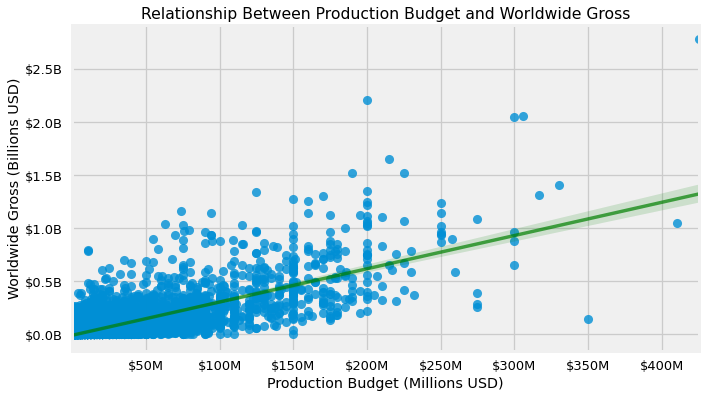

In [33]:
# initiate plot
fig, ax = plt.subplots(figsize=(10,6))
sns.regplot(x=tn['p_prod_budg']/1000000, y=tn['p_ww_gross']/1000000000, ax=ax, line_kws={"color":"green","alpha":0.7})

# customize labels
ax.set_xlabel('Production Budget (Millions USD)')
ax.xaxis.set_major_formatter('${x:1.0f}M') 
ax.set_ylabel('Worldwide Gross (Billions USD)')
ax.yaxis.set_major_formatter('${x}B') 
ax.set_title('Relationship Between Production Budget and Worldwide Gross');

### Worldwide Gross grouped by Month of Release: (5,782 films)

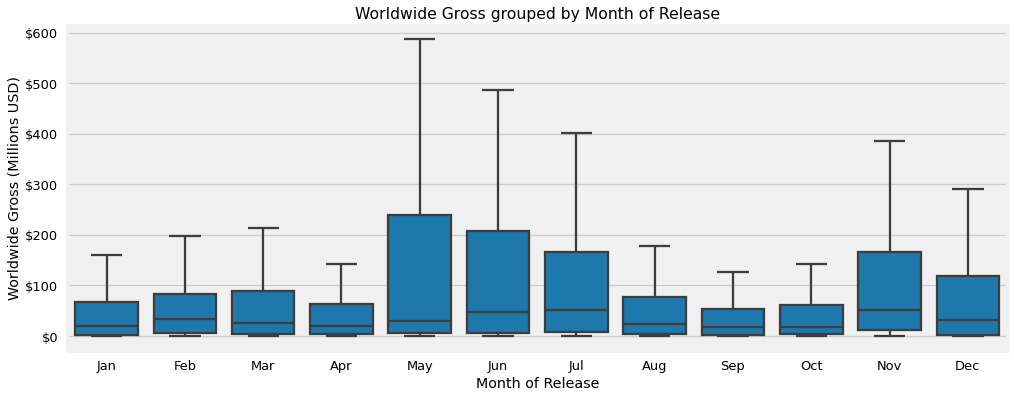

In [34]:
# use SQL to ORDER BY 'p_month' so it's Jan --> Dec:
pysqldf = lambda q: sqldf(q, globals())
q = """SELECT *
     FROM tn
     ORDER BY p_month;"""
tn = pysqldf(q)

# initiate plot
fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(x=tn['p_month'], y=tn['p_ww_gross']/1000000, showfliers = False, ax=ax, color='#067ec4')

# customize labels
ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.set_title('Worldwide Gross grouped by Month of Release')
ax.set_xlabel("Month of Release")
ax.set_ylabel("Worldwide Gross (Millions USD)")
ax.yaxis.set_major_formatter('${x:1.0f}');

### Worldwide Gross per Month of Release, grouped by Genre:

To plot the genres individually, each film's genre categories needed to be separated. This resulted in the worldwide gross being duplicated with each genre. In order to compensate for these inflated values a new column was created that divided the worldwide gross equally among each films genres. In addition to using these divided-gross values for the plots below, they were also used to calculate each genres mean value, and the top raking genres were then based off of that mean value. 
 

### Seperating the genres:

__Drop__ rows that have none value

In [35]:
# before graphing need to split then explode 'imdb_genres'

# drop the row if 'imdb_genres' has None value 
# ----------make a list of none-value rows to drop----------------------------
genres = tnimdb['imdb_genres']
need_to_drop_these_rows = [index for index in range(len(genres)) if genres[index] == None]

# ----------drop non-value rows from 'need_to_drop_these_rows' list-----------
tnimdb.drop(labels=need_to_drop_these_rows, axis=0, inplace=True)

# ----------after drop, reset index-------------------------------------------
tnimdb.reset_index()

# check
tnimdb.tail()

,p_title,p_prod_budg,p_ww_gross,p_date,p_month,imdb_genres,p_runtime_mins,director,writer,p_year
3320,Zoom,35000000,12506188,2006-08-11,8,"Animation,Comedy,Drama",96.0,Pedro Morelli,Pedro Morelli,2015
3321,Zoom,35000000,12506188,2006-08-11,8,"Comedy,Drama,Romance",158.0,Prashanth Raj,Kaviraj,2016
3322,Zootopia,150000000,1019429616,2016-03-04,3,"Adventure,Animation,Comedy",108.0,Byron Howard,Byron Howard,2016
3323,Zulu,16000000,1844228,2013-12-31,12,"Crime,Drama,Thriller",110.0,Jérôme Salle,Julien Rappeneau,2013
3324,xXx: Return of Xander Cage,85000000,345033359,2017-01-20,1,"Action,Adventure,Thriller",107.0,D.J. Caruso,Rich Wilkes,2017


__Add__ new columns: 
- 'genres_exploded' - seperated genres (multiple genres still group together but split on the comma which seperates them into differnt entities)
- 'gross_divided' - worldwide gross divided by the number of genres from 'genres_exploded'

In [36]:
# ------add new column: df = split on commas----------------------------------
tnimdb['genres_exploded'] = [clean_genres.split(',') for clean_genres in tnimdb['imdb_genres']]   


# ------new column with ww gross divided by number of genres------------------
tnimdb['gross_divided'] = [tnimdb['p_ww_gross'].iloc[i]//len(tnimdb['genres_exploded'].iloc[i]) \
                           for i in range(len(tnimdb))]

In [37]:
# check that new columns are there
tnimdb.tail()

,p_title,p_prod_budg,p_ww_gross,p_date,p_month,imdb_genres,p_runtime_mins,director,writer,p_year,genres_exploded,gross_divided
3320,Zoom,35000000,12506188,2006-08-11,8,"Animation,Comedy,Drama",96.0,Pedro Morelli,Pedro Morelli,2015,"[Animation, Comedy, Drama]",4168729
3321,Zoom,35000000,12506188,2006-08-11,8,"Comedy,Drama,Romance",158.0,Prashanth Raj,Kaviraj,2016,"[Comedy, Drama, Romance]",4168729
3322,Zootopia,150000000,1019429616,2016-03-04,3,"Adventure,Animation,Comedy",108.0,Byron Howard,Byron Howard,2016,"[Adventure, Animation, Comedy]",339809872
3323,Zulu,16000000,1844228,2013-12-31,12,"Crime,Drama,Thriller",110.0,Jérôme Salle,Julien Rappeneau,2013,"[Crime, Drama, Thriller]",614742
3324,xXx: Return of Xander Cage,85000000,345033359,2017-01-20,1,"Action,Adventure,Thriller",107.0,D.J. Caruso,Rich Wilkes,2017,"[Action, Adventure, Thriller]",115011119


__Explode__ 'genres_exploded' seperating each genre into a new row (worldwide gross is duplicated in each new row)

In [38]:
# ----------explode the 'genres_exploded' column------------------------------
tnimdb = tnimdb.explode('genres_exploded', ignore_index=False)

__Final Check__ to ensure DF is as needed

In [39]:
# check that each genre is seperated
tnimdb.tail()

,p_title,p_prod_budg,p_ww_gross,p_date,p_month,imdb_genres,p_runtime_mins,director,writer,p_year,genres_exploded,gross_divided
3323,Zulu,16000000,1844228,2013-12-31,12,"Crime,Drama,Thriller",110.0,Jérôme Salle,Julien Rappeneau,2013,Drama,614742
3323,Zulu,16000000,1844228,2013-12-31,12,"Crime,Drama,Thriller",110.0,Jérôme Salle,Julien Rappeneau,2013,Thriller,614742
3324,xXx: Return of Xander Cage,85000000,345033359,2017-01-20,1,"Action,Adventure,Thriller",107.0,D.J. Caruso,Rich Wilkes,2017,Action,115011119
3324,xXx: Return of Xander Cage,85000000,345033359,2017-01-20,1,"Action,Adventure,Thriller",107.0,D.J. Caruso,Rich Wilkes,2017,Adventure,115011119
3324,xXx: Return of Xander Cage,85000000,345033359,2017-01-20,1,"Action,Adventure,Thriller",107.0,D.J. Caruso,Rich Wilkes,2017,Thriller,115011119


### Plotting the exploded genres:
__Use SQL Lite query__ so genres are ordered alphabetically once plotted:

In [40]:
# use SQL so genres are alphabetized: ORDER BY month, genre:
# ----------JANUARY------------
q1 = """SELECT *
     FROM tnimdb
     ORDER BY p_month, genres_exploded;"""
tnimdb_sql = pysqldf(q1)

#check that all the info needed in here
tnimdb_sql.tail()

,p_title,p_prod_budg,p_ww_gross,p_date,p_month,imdb_genres,p_runtime_mins,director,writer,p_year,genres_exploded,gross_divided
7304,Django Unchained,100000000,449948323,2012-12-25 00:00:00.000000,12,"Drama,Western",165.0,Quentin Tarantino,Quentin Tarantino,2012,Western,224974161
7305,Doc Holliday's Revenge,1000000,0,2014-12-31 00:00:00.000000,12,Western,84.0,David DeCoteau,Rolfe Kanefsky,2014,Western,0
7306,The Ridiculous 6,60000000,0,2015-12-11 00:00:00.000000,12,"Comedy,Western",119.0,Frank Coraci,Adam Sandler,2015,Western,0
7307,The Warrior's Way,42000000,8514325,2010-12-03 00:00:00.000000,12,"Action,Fantasy,Western",100.0,Sngmoo Lee,Scott Reynolds,2010,Western,2838108
7308,True Grit,35000000,252276928,2010-12-22 00:00:00.000000,12,"Adventure,Drama,Western",110.0,Ethan Coen,Ethan Coen,2010,Western,84092309


__Create a dictionary__ of months with: 
- Keys: months spelled out 
- Values: months as intergers

In [41]:
# dictionary of months - words:integers
months_words_ints = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12       
}

__Create for loop__ to iterate over dictionary of months and plot each month individually:

( __<font color=gold>GOLD</font> &#9651;'s mark the mean__)

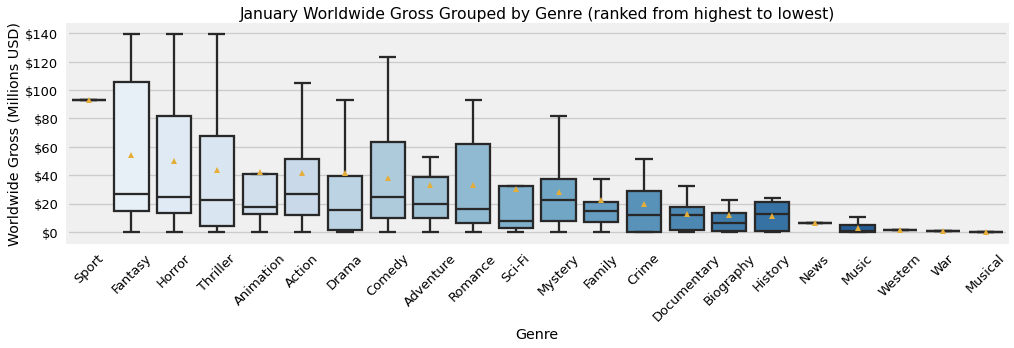

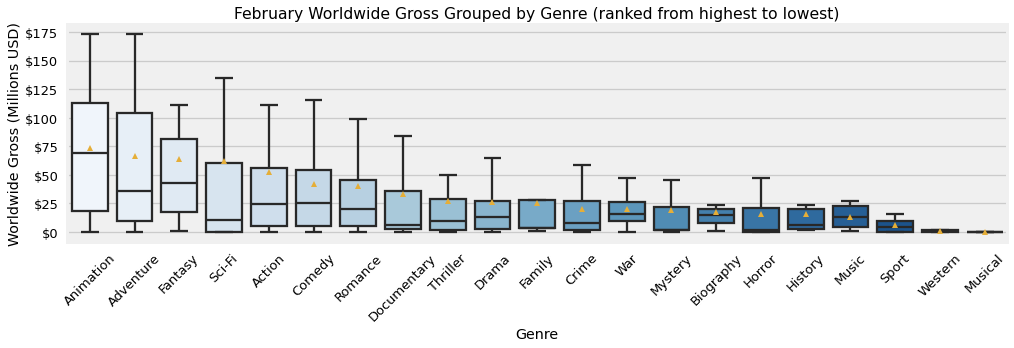

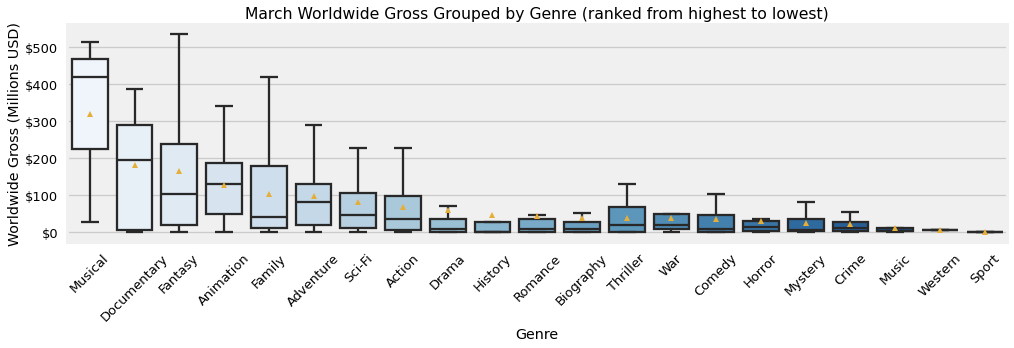

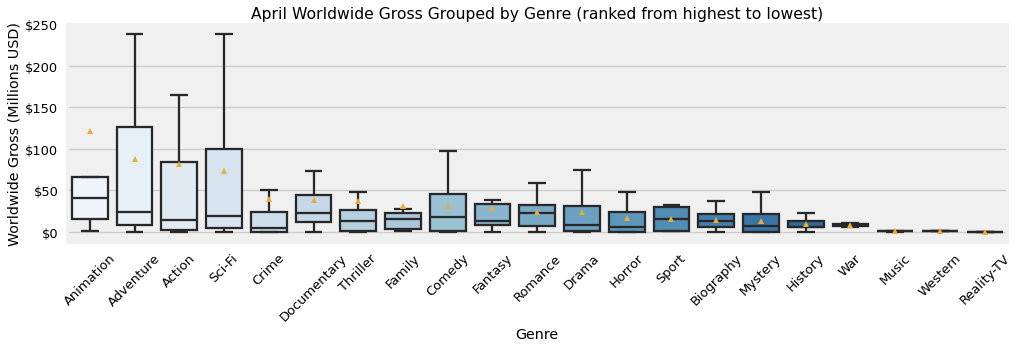

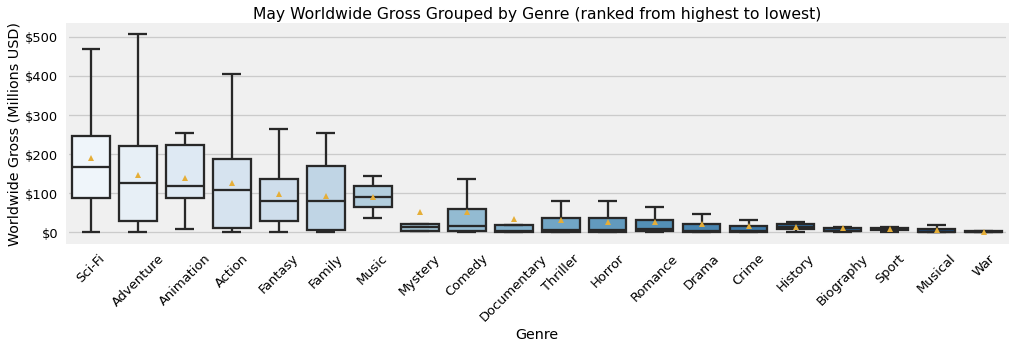

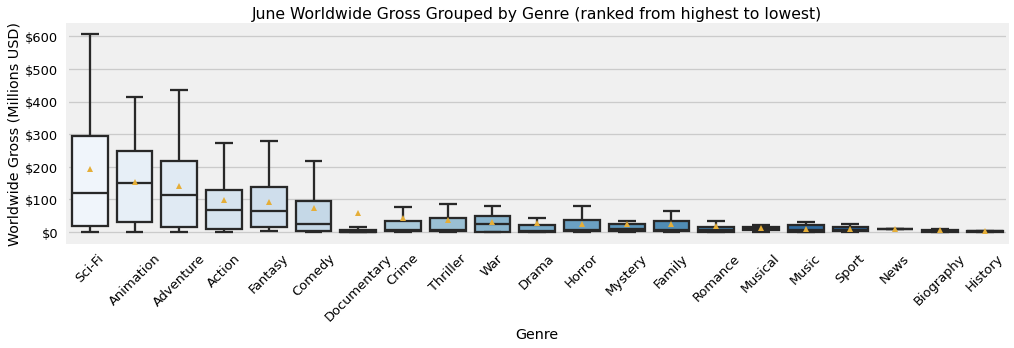

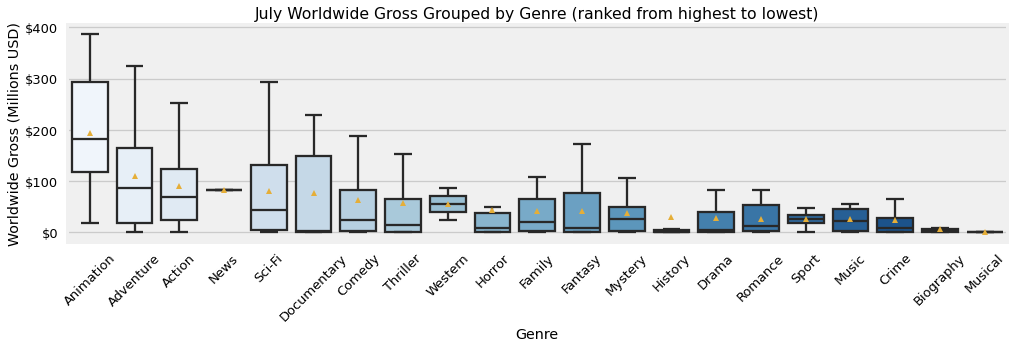

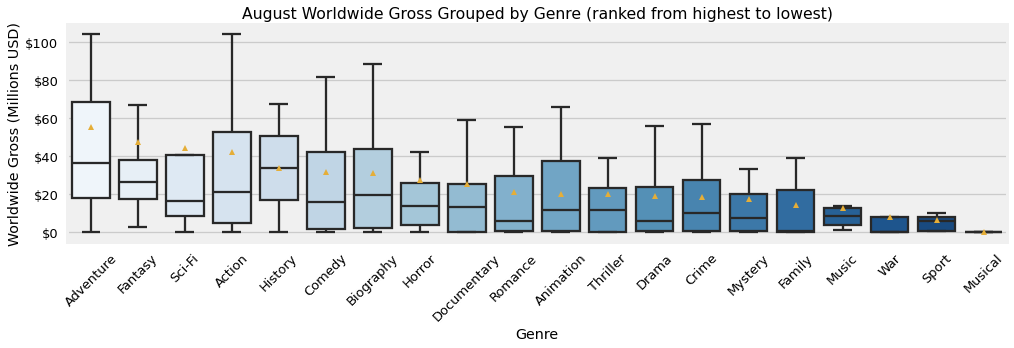

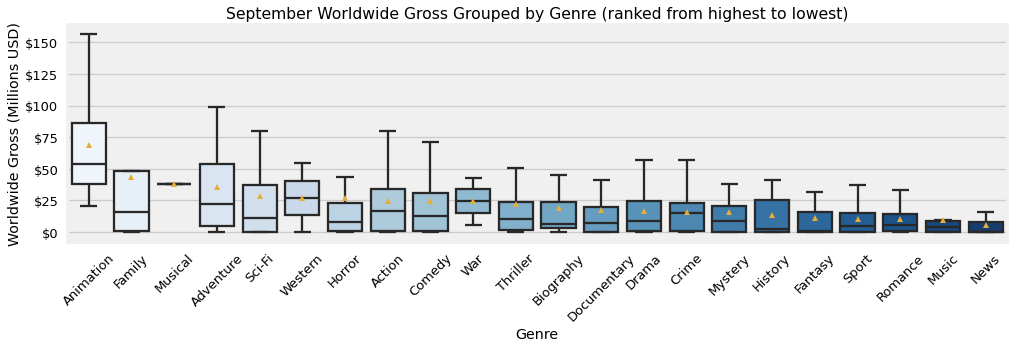

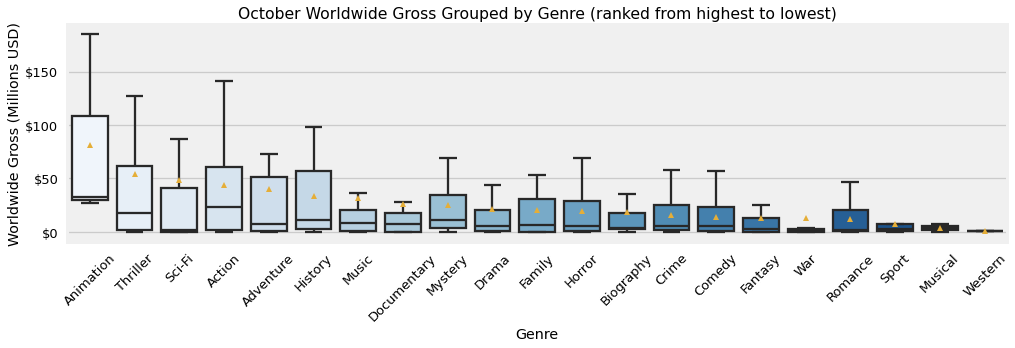

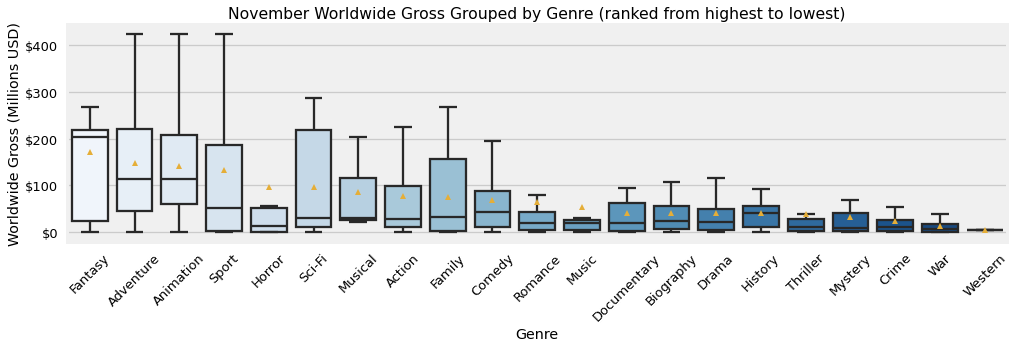

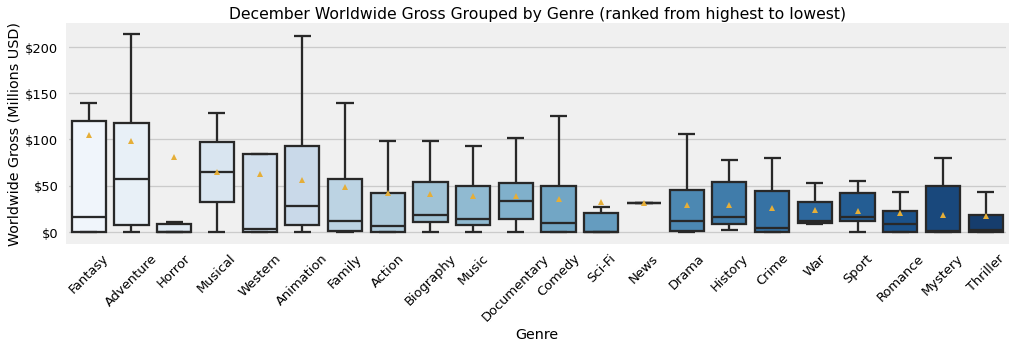

In [42]:
# create for loop to iterate over the months and plot each month individually
for month_word,month_int in months_words_ints.items():
# ----------seperate by month----------------------------------------
    DF = tnimdb_sql[tnimdb_sql['p_month'] == month_int]
    
    # tuple genre with mean of 'gross_divided'
    info_tuples = [(DF[DF['genres_exploded'] == genre]['gross_divided'].mean(), genre) for genre in DF['genres_exploded'].unique()]
    # sort the tuples 
    ranked_info = sorted(info_tuples, reverse=True)
    #make list of just genres
    ranked_genres = [i[1] for i in ranked_info]

# ----------initiate plot--------------------------------------------
    fig, ax = plt.subplots(figsize=(15,4))
    sns.boxplot(x=DF['genres_exploded'], y=DF['gross_divided']/1000000, showfliers = False, \
                ax=ax, palette='Blues', showmeans=True, order=ranked_genres)

# ----------Customize labels-----------------------------------------
    ax.set_title(f'{month_word} Worldwide Gross Grouped by Genre (ranked from highest to lowest)')
    ax.set_xlabel("Genre")
    ax.set_ylabel("Worldwide Gross (Millions USD)")
    ax.yaxis.set_major_formatter('${x:1.0f}') 
    ax.set_xticks(range(0, len(ranked_genres)))
    ax.set_xticklabels(ranked_genres, rotation=45)
    ;

### Recap:
#### Top 3 Genres by Month:
- __January:__ ('Sport', 'Animation', 'Horror')
- __February:__ ('Musical', 'Music', 'Adventure')
- __March:__ ('Musical', 'Fantasy', 'Documentary')
- __April:__ ('Animation', 'Adventure', 'Sci-Fi')
- __May:__ ('Animation', 'Sci-Fi', 'Adventure')
- __June:__ ('Sci-Fi', 'Animation', 'Adventure')
- __July:__ ('Animation', 'Adventure', 'Action')
- __August:__ ('Fantasy', 'Adventure', 'Action')
- __September:__ ('Animation', 'Family', 'Musical')
- __Ocotober:__ ('Animation', 'Sci-Fi', 'Thriller')
- __November:__ ('Fantasy', 'Animation', 'Adventure')
- __December:__ ('Horror', 'Fantasy', 'Adventure')


### Worldwide Gross grouped by Rating: 
## <font color=red>Re submission notes:</font>
__(This entire section has been updated)__
- I pulled out NR movies to see if insignificant enough to drop
 - only 2 NR movies, dropped NR so plot looks cleaner
- ranked Rating by mean of worldwide gross
- included showmeans on box plots
- as suggested, I made a super simplified visualization to compare Production Budget and Worlwide Gross by Rating (aiming for 5th grader comprehesion)


In [43]:
# ----------make a list of 'NR' movies to maybe drop, so plot looks cleaner--
ratings = rttnimdb['rating']
drop_these = [index for index in range(len(ratings)) if ratings[index] == 'NR']
drop_these

[20, 27]

In [44]:
# ---------- only 2 movies, ok to drop 'NR' movies---------------------------
rttnimdb.drop(labels=drop_these, axis=0, inplace=True)

[Text(0, 0, 'PG-13'), Text(1, 0, 'PG'), Text(2, 0, 'R')]

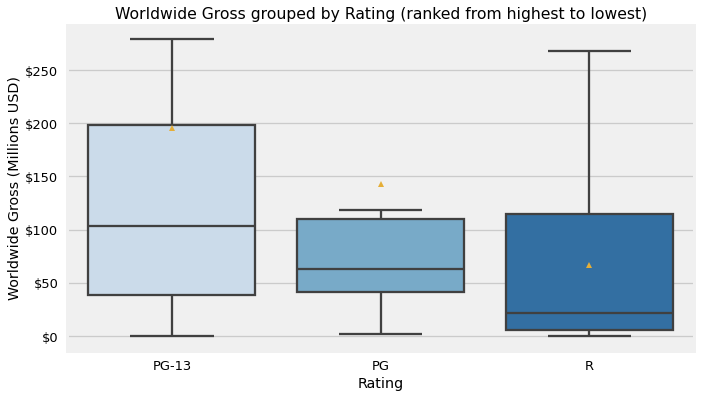

In [45]:
# tuple rating with mean of 'p_ww_gross'
info_tuples = [(rttnimdb[rttnimdb['rating'] == rating]['p_ww_gross'].mean(), rating) for rating in rttnimdb['rating'].unique()]
# sort the tuples 
ranked_means = sorted(info_tuples, reverse=True)
#make list of just rating
ranked_ratings = [i[1] for i in ranked_means]

# initiate plot
fig, ax = plt.subplots(figsize=(10,6))
sns.boxplot(x=rttnimdb['rating'], y=rttnimdb['p_ww_gross']/1000000, showfliers = False, ax=ax, showmeans=True, palette='Blues', order=ranked_ratings)

# customize labels
ax.set_title('Worldwide Gross grouped by Rating (ranked from highest to lowest)')
ax.set_xlabel("Rating")
ax.set_ylabel("Worldwide Gross (Millions USD)")
ax.yaxis.set_major_formatter('${x:1.0f}')

ax.set_xticks(range(0, len(ranked_ratings)))
ax.set_xticklabels(ranked_ratings)

In [46]:
# make new df with just the numbers I need (ratings, mean pro budget, mean ww gross)

barplot_df = pd.DataFrame({'Rating': [rating for rating in rttnimdb['rating'].unique()],
                   'Mean Production Budget': [rttnimdb[rttnimdb['rating'] == rating]['p_prod_budg'].mean() for rating in rttnimdb['rating'].unique()],
                   'Mean Worldwide Gross': [rttnimdb[rttnimdb['rating'] == rating]['p_ww_gross'].mean() for rating in rttnimdb['rating'].unique()]})

barplot_df

,Rating,Mean Production Budget,Mean Worldwide Gross
0,R,2.570556e+07,6.631199e+07
1,PG-13,5.493333e+07,1.957489e+08
2,PG,6.645000e+07,1.424724e+08


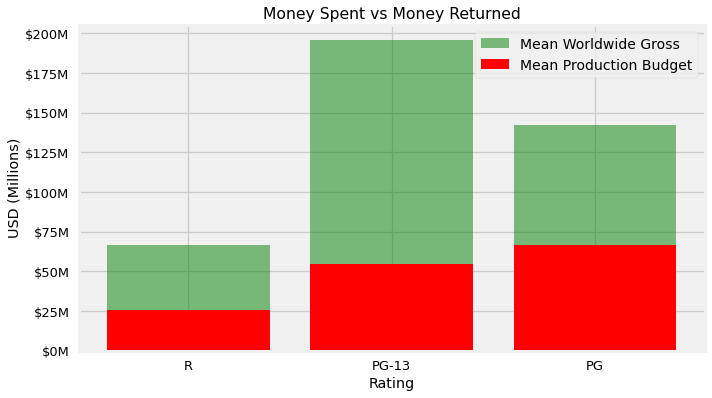

In [47]:
# make overlapping bar plot using ratings: mean ww gross and mean production budget

# initiate plot
fig, ax = plt.subplots(figsize=(10,6))
ax.yaxis.set_major_formatter('${x:1.0f}')
ax.bar(barplot_df['Rating'], barplot_df['Mean Worldwide Gross']/1000000, color='green', label='Mean Worldwide Gross', alpha=0.5)
ax.bar(barplot_df['Rating'], barplot_df['Mean Production Budget']/1000000, color='red', label='Mean Production Budget', alpha=1)

# labels
ax.set_title('Money Spent vs Money Returned')
ax.set_xlabel("Rating")
ax.set_ylabel("USD (Millions)")
ax.yaxis.set_major_formatter('${x:1.0f}M')
ax.legend(fontsize=14);

## <font color=red>Re submission notes:</font>
New data from re join (with director and year) yeilds information which changes my recommendations from recommending a PG movie to PG-13 movie. Results, Conclustions, & Next steps have been updated

# Results
- Production Budget, Month of Release, Genre, and Rating were all positively correlated with Worldwide Gross. 
- Production Budget has the strongest correlation with Worldwide Gross
- May & June are top two grossing months followed by July & November
- Animation & Adventure are in all those months’ Top 3 Genres
- May & June have the same top 3 Genres just in different order
- Based on the mean value, PG-13 is the top grossing movie rating. Furthermore, this is achieved with lower production budget on average compared to PG movies 
- An R rating seems to significantly limit worldwide gross

 

# Conclusions
Deciding to fund a film can be risky, by understanding the correlation between worldwide gross and the aforementioned factors TMPC can optimism revenue potential by aligning all positively correlated factors.

-	__Bank on the budget:__ higher production budget yields higher worldwide gross
-	__The month matters:__ May & June are the top two months to release a film
-	__Each months top genres matter too:__ May & June have the same top 3 grossing genres: Animation, Sci-Fi, & Adventure 
-	__R is NOT for Revenue:__ R rated movies restrict your audience and your worldwide gross


## Next Steps
1. Release a film in May or June
2. The film should contain one of the following genres:
 - Adventure
 - Animation
 - Sci-Fi 
3. The movie should be rated PG-13
4. Don’t shy away from higher production cost to increase Worldwide Gross.

### _Limitations to consider._
- This analysis was based strictly on worldwide gross and does not reflect other factors which influence profitability of a film. A few examples being: postproduction costs, merchandising income, marketing, return on investment, foreign rights, distribution fees… etc. 
- Investigation into the return on investment (in this case difference between worldwide gross and production budget) may yeild additional insight into ideal genres, ratings, or months-of-release.
- The data frames contain films dating back a century. Further analysis is needed to measure if the analysis is skewed (specifically the Musical genre) by these older films and not reflective current trends. 
- No calculations to account for inflation were done.

# Just the numbers: 
## Pearson correlation between worldwide gross and:
- __Production Budget:__ 0.748
- __Month of Release:__ 0.030
- __Rating:__ 0.151
- __Genre:__ 0.144



In [48]:
# PRODUCTION BUDGET ######################################
# ----------correlation between worldwide gross and production budget------------
budget_gross_corr = tn['p_ww_gross'].corr(tn['p_prod_budg'], method='pearson')

# ----------print results--------------------------------------------------------
print(f"The Pearson correlation between production budget to worldwide gross: {round(budget_gross_corr,3)}")


# MONTH OF RELEASE ######################################
# ----------correlation between month of release and wwgross---------------------
month_gross_corr = tn['p_ww_gross'].corr(tn['p_month'], method='pearson')

# ----------print results--------------------------------------------------------
print(f"The Pearson correlation between month of release and worldwide gross: {round(month_gross_corr,3)}")


# RATING ##############################################
# to evaluate corr between gross and rating, assign rating string an int value 

# ----------get unique values---------------------------------------------------
unique_ratings = rttnimdb['rating'].unique() 

# ----------make list of int values == to length of unique ratings--------------
rating_ints = [index for index in range(len(unique_ratings))]

# ----------make ditionary with unique values as keys and integers as values----
rating_int_dict = {unique_ratings[i]: rating_ints[i] for i in range(len(rating_ints))}

# ----------make list to assign to new column-----------------------------------
rating_int_col = [rating_int_dict[rating] for rating in rttnimdb['rating']]

# ----------add new column------------------------------------------------------
rttnimdb['rating_int'] = rating_int_col

# ----------correlation between worldwide gross and ratings values--------------
rating_gross_corr = rttnimdb['p_ww_gross'].corr(rttnimdb['rating_int'], method='pearson')

# ----------print results--------------------------------------------------------
print(f"The Pearson correlation between rating and worldwide gross: {round(rating_gross_corr,3)}")


# GENRE ##############################################
# to evaluate corr between gross and genre, assign genre string an int value

# ----------get unique values---------------------------------------------------
unique_genres = tnimdb['genres_exploded'].unique()

# ----------make list of integers == to length of unique ratings----------------
genre_ints = [index for index in range(len(unique_genres))]

# ----------make ditionary with unique values as keys and integers as values----
genre_int_dict = {unique_genres[i]: genre_ints[i] for i in range(len(genre_ints))}

# ----------make list to assign to new column-----------------------------------
genre_int_col = [genre_int_dict[genre] for genre in tnimdb['genres_exploded']]

# ----------add new column------------------------------------------------------
tnimdb['genre_int'] = genre_int_col

# ----------correlation between worldwide gross and ratings values--------------
genre_gross_corr = tnimdb['p_ww_gross'].corr(tnimdb['genre_int'], method='pearson')

# ----------print results--------------------------------------------------------
print(f"The Pearson correlation between rating and worldwide gross: {round(genre_gross_corr,3)}")

The Pearson correlation between production budget to worldwide gross: 0.748
The Pearson correlation between month of release and worldwide gross: 0.03
The Pearson correlation between rating and worldwide gross: 0.191
The Pearson correlation between rating and worldwide gross: 0.143


## More numbers:
- Min
- Max
- Median
- Mean
- Standard Deviation


### For the following:

- Production Budget
- Worldwide Gross
- Production Budget by Rating
- Production Budget by Genre
- Worldwide Gross by Rating
- Worldwide Gross by Genre (using divided worldwide gross)
- Worldwide Gross by Month

In [49]:
# descriptive statistics for all features used in the analysis
# features used: 
    #production budget (tn)
print("PRODUCTION BUDGET:")
print(f"Min: {tn['p_prod_budg'].min()}, Max: {tn['p_prod_budg'].max()}, Median: {tn['p_prod_budg'].median()}, Mean: {tn['p_prod_budg'].mean()}, Standard Deviation: {tn['p_prod_budg'].std()}")
print()
print()
    #worldwide gross (tn)
print("WORLDWIDE GROSS:")
print(f"Min: {tn['p_ww_gross'].min()}, Max: {tn['p_ww_gross'].max()}, Median: {tn['p_ww_gross'].median()}, Mean: {tn['p_ww_gross'].mean()}, Standard Deviation: {tn['p_ww_gross'].std()}")
print()
print()
    # production budget by rating (rttnimdb)
print("PRODUCTION BUDGET BY RATING:")
for rating in rttnimdb['rating'].unique():
    subset = rttnimdb[rttnimdb['rating'] == rating]
    print(rating)
    print(f"Min: {subset['p_prod_budg'].min()}, Max: {subset['p_prod_budg'].max()}, Median: {subset['p_prod_budg'].median()}, Mean: {subset['p_prod_budg'].mean()}, Standard Deviation: {subset['p_prod_budg'].std()}")
print()
    # production budget by genre (tnimdb)
print()
print("PRODUCTION BUDGET BY GENRE:")
for genre in tnimdb['genres_exploded'].unique():
    subset = tnimdb[tnimdb['genres_exploded'] == genre]
    print(genre)
    print(f"Min: {subset['p_prod_budg'].min()}, Max: {subset['p_prod_budg'].max()}, Median: {subset['p_prod_budg'].median()}, Mean: {subset['p_prod_budg'].mean()}, Standard Deviation: {subset['p_prod_budg'].std()}")
print()
    # ww gross by rating (rttnimdb)
print()
print("WORLDWIDE GROSS BY RATING:")
for rating in rttnimdb['rating'].unique():
    subset = rttnimdb[rttnimdb['rating'] == rating]
    print(rating)
    print(f"Min: {subset['p_ww_gross'].min()}, Max: {subset['p_ww_gross'].max()}, Median: {subset['p_ww_gross'].median()}, Mean: {subset['p_ww_gross'].mean()}, Standard Deviation: {subset['p_ww_gross'].std()}")
print()
    # ww gross by genre (tnimdb)
print()
print("WORLDWIDE GROSS BY GENRE (using films gross divided by films number of genres):")
for genre in tnimdb['genres_exploded'].unique():
    subset = tnimdb[tnimdb['genres_exploded'] == genre]
    print(genre)
    print(f"Min: {subset['gross_divided'].min()}, Max: {subset['gross_divided'].max()}, Median: {subset['gross_divided'].median()}, Mean: {subset['gross_divided'].mean()}, Standard Deviation: {subset['gross_divided'].std()}")
print()
    # ww gross by month (tnimdb)
print()
print("WORLDWIDE GROSS BY MONTH:")
for month in tnimdb['p_month'].unique():
    subset = tnimdb[tnimdb['p_month'] == month]
    print(month)
    print(f"Min: {subset['p_ww_gross'].min()}, Max: {subset['p_ww_gross'].max()}, Median: {subset['p_ww_gross'].median()}, Mean: {subset['p_ww_gross'].mean()}, Standard Deviation: {subset['p_ww_gross'].std()}")
print()
print()
print("WORLDWIDE GROSS of GENRES by MONTH (using films gross divided by films number of genres):")
    # ww gross of genres by month -using gross divided by number of genres- (tnimdb)
for key,val in months_words_ints.items():
    DF = tnimdb[tnimdb['p_month'] == val]
    print()
    print(f'################# {key} #################')
    for genre in DF['genres_exploded'].unique():
        subset = DF[DF['genres_exploded'] == genre]
        print(genre)
        print(f"Min: {subset['gross_divided'].min()}, Max: {subset['gross_divided'].max()}, Median: {subset['gross_divided'].median()}, Mean: {subset['gross_divided'].mean()}, Standard Deviation: {subset['gross_divided'].std()}")
    

PRODUCTION BUDGET:
Min: 1100, Max: 425000000, Median: 17000000.0, Mean: 31587757.0965064, Standard Deviation: 41812076.82694309


WORLDWIDE GROSS:
Min: 0, Max: 2776345279, Median: 27984448.5, Mean: 91487460.90643376, Standard Deviation: 174719968.77890477


PRODUCTION BUDGET BY RATING:
R
Min: 750000, Max: 90000000, Median: 15000000.0, Mean: 25705555.555555556, Standard Deviation: 26786629.605850484
PG-13
Min: 3000000, Max: 250000000, Median: 30000000.0, Mean: 54933333.333333336, Standard Deviation: 59536678.5431806
PG
Min: 7000000, Max: 180000000, Median: 40000000.0, Mean: 66450000.0, Standard Deviation: 63551575.730093256


PRODUCTION BUDGET BY GENRE:
Crime
Min: 25000, Max: 250000000, Median: 20000000.0, Mean: 27165578.982233502, Standard Deviation: 29320852.518468186
Drama
Min: 1400, Max: 210000000, Median: 13000000.0, Mean: 23025368.58783008, Standard Deviation: 30660834.68909677
Horror
Min: 1400, Max: 425000000, Median: 7000000.0, Mean: 18304581.572481573, Standard Deviation: 34290

Min: 0, Max: 419733235, Median: 40657445.5, Mean: 101717884.92307693, Standard Deviation: 113202858.56563675
Romance
Min: 0, Max: 419733235, Median: 8795679.0, Mean: 42844723.82857143, Standard Deviation: 86013819.00385132
Musical
Min: 26316255, Max: 512745555, Median: 419733235.0, Mean: 319598348.3333333, Standard Deviation: 258212340.17845106
Music
Min: 1078, Max: 30892982, Median: 2851627.0, Mean: 9149328.5, Standard Deviation: 14585201.788831433
Sci-Fi
Min: 0, Max: 374353850, Median: 44910479.0, Mean: 81757353.0, Standard Deviation: 98480761.61019255
Western
Min: 4223476, Max: 4223476, Median: 4223476.0, Mean: 4223476.0, Standard Deviation: nan
Biography
Min: 0, Max: 192998948, Median: 8450249.0, Mean: 38392898.21052632, Standard Deviation: 69946887.4650615
Sport
Min: 22555, Max: 205272, Median: 141799.5, Mean: 127856.5, Standard Deviation: 76455.70518280503
History
Min: 0, Max: 192998948, Median: 399836.0, Mean: 45852931.333333336, Standard Deviation: 83848672.32340306
Animation
M

Min: 0, Max: 386778724, Median: 22376681.0, Mean: 62132856.011764705, Standard Deviation: 88187050.30300064
Adventure
Min: 0, Max: 386778724, Median: 86667371.0, Mean: 108570905.6734694, Standard Deviation: 102287358.98732749
Family
Min: 0, Max: 181154857, Median: 18643821.0, Mean: 41527449.14285714, Standard Deviation: 52180763.59539458
Musical
Min: 0, Max: 690912, Median: 531806.0, Mean: 407572.6666666667, Standard Deviation: 361822.17838232825
Documentary
Min: 0, Max: 457507776, Median: 1381824.0, Mean: 76277313.1764706, Standard Deviation: 124221339.5047954
Mystery
Min: 6600, Max: 172533333, Median: 26017127.5, Mean: 37523104.88888889, Standard Deviation: 46815126.895936005
Sci-Fi
Min: 2933, Max: 293388783, Median: 42411463.0, Mean: 79860253.60869566, Standard Deviation: 92340194.1754469
Action
Min: 0, Max: 542219549, Median: 67591914.5, Mean: 88991835.41071428, Standard Deviation: 98308669.13318329
Sport
Min: 150198, Max: 47078228, Median: 26086956.5, Mean: 24850584.75, Standard D

Sci-Fi
Min: 0, Max: 284542868, Median: 2032510.0, Mean: 48376464.84210526, Standard Deviation: 91502890.11868215
Fantasy
Min: 0, Max: 73413907, Median: 2230042.0, Mean: 12944165.1875, Standard Deviation: 21196752.914898925
Animation
Min: 27050262, Max: 184995825, Median: 32550514.0, Mean: 81532200.33333333, Standard Deviation: 89644321.71024293

################# November #################
Crime
Min: 0, Max: 115307576, Median: 10869339.0, Mean: 23254349.555555556, Standard Deviation: 29622143.035629902
Drama
Min: 0, Max: 424156636, Median: 21229739.0, Mean: 40464292.54861111, Standard Deviation: 65822862.09991547
Horror
Min: 0, Max: 798008101, Median: 11656932.5, Mean: 96390324.9090909, Standard Deviation: 230340566.10475475
Adventure
Min: 96252, Max: 424156636, Median: 112986861.5, Mean: 148811303.18, Standard Deviation: 121396826.42528236
Biography
Min: 96252, Max: 298328447, Median: 24298136.0, Mean: 40652160.59375, Standard Deviation: 56550220.315787785
Comedy
Min: 0, Max: 42415663

## And even more numbers:

### Top ranking genres (determined by highest means of genres divided-gross, which is a films worldwide gross divided equally amoung its genres)

#### Top 3 Genres by Month:
- __January:__ ('Sport', 'Animation', 'Horror')
- __February:__ ('Musical', 'Music', 'Adventure')
- __March:__ ('Musical', 'Fantasy', 'Documentary')
- __April:__ ('Animation', 'Adventure', 'Sci-Fi')
- __May:__ ('Animation', 'Sci-Fi', 'Adventure')
- __June:__ ('Sci-Fi', 'Animation', 'Adventure')
- __July:__ ('Animation', 'Adventure', 'Action')
- __August:__ ('Fantasy', 'Adventure', 'Action')
- __September:__ ('Animation', 'Family', 'Musical')
- __Ocotober:__ ('Animation', 'Sci-Fi', 'Thriller')
- __November:__ ('Fantasy', 'Animation', 'Adventure')
- __December:__ ('Horror', 'Fantasy', 'Adventure')

In [50]:
for month_word,month_int in months_words_ints.items():
    DF = tnimdb[tnimdb['p_month'] == month_int]
    
    # tuple genre with mean of 'gross_divided'
    info_tuples = [(DF[DF['genres_exploded'] == genre]['gross_divided'].mean(), genre) for genre in DF['genres_exploded'].unique()]
    # sort the tuples 
    ranked_info = sorted(info_tuples, reverse=True)
    #make list of just genres
    ranked_genres = [i[1] for i in ranked_info]
    #top three
    top = ranked_genres[:3]
    
    print(f"{month_word} top 3 genres are: {top}")

January top 3 genres are: ['Sport', 'Fantasy', 'Horror']
February top 3 genres are: ['Animation', 'Adventure', 'Fantasy']
March top 3 genres are: ['Musical', 'Documentary', 'Fantasy']
April top 3 genres are: ['Animation', 'Adventure', 'Action']
May top 3 genres are: ['Sci-Fi', 'Adventure', 'Animation']
June top 3 genres are: ['Sci-Fi', 'Animation', 'Adventure']
July top 3 genres are: ['Animation', 'Adventure', 'Action']
August top 3 genres are: ['Adventure', 'Fantasy', 'Sci-Fi']
September top 3 genres are: ['Animation', 'Family', 'Musical']
October top 3 genres are: ['Animation', 'Thriller', 'Sci-Fi']
November top 3 genres are: ['Fantasy', 'Adventure', 'Animation']
December top 3 genres are: ['Fantasy', 'Adventure', 'Horror']


# Questions...

### Thank you!

__Email:__ cassigroesbeck@gmail.com

__GitHub:__ @AgathaZareth

__LinkedIn:__ linkedin.com/in/cassarra-groesbeck-a64b75229
